# Environment

In [1]:
!pip install transformers
!pip install networkx
!pip install wordcloud

In [2]:
from google.colab import drive
from transformers import pipeline
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pandas as pd
import networkx as nx
import re
import ast
import matplotlib.pyplot as plt
# plt.style.use('seaborn-v0_8')
plt.style.use('dark_background')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Auxilary Methods

# Dataset Configuration (Version Vaccine)

In [3]:
tweets = pd.read_csv('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6414/Datasets/vaccines.csv')
print(f'Original Dataset Shape: {tweets.shape}')
tweets.dropna(axis=0)
print(f'After dropping bad rows: {tweets.shape}')

Original Dataset Shape: (209929, 36)
After dropping bad rows: (209929, 36)


In [4]:
print(f'Dataset Shape: {tweets.shape}')
print(f'Columns: {tweets.keys}')

Dataset Shape: (209929, 36)
Columns: <bound method NDFrame.keys of                          id      conversation_id  \
0       1319174447442448384  1319153697406906369   
1       1319174381503852544  1319174381503852544   
2       1319174114779643905  1319174114779643905   
3       1319174091232833536  1319172728851591174   
4       1319174029488476160  1319174029488476160   
...                     ...                  ...   
209924  1227994124709744640  1227984370469933057   
209925  1227936762280005632  1227935124924358656   
209926  1227604213880041474  1227555942889209856   
209927  1227437428811739145  1227437428811739145   
209928  1227373636484550658  1227368264373653505   

                                     created_at        date      time  \
0       2020-10-22 12:41:12 India Standard Time  2020-10-22  12:41:12   
1       2020-10-22 12:40:56 India Standard Time  2020-10-22  12:40:56   
2       2020-10-22 12:39:52 India Standard Time  2020-10-22  12:39:52   
3       2020-10-

# Text Classification Model Configuration (Version Vaccine)

In [ ]:
sentiment_model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest" #@param {type:"string"}
fake_news_model_path = "spencer-gable-cook/COVID-19_Misinformation_Detector" #@param {type:"string"}

sentiment = pipeline(
    task='sentiment-analysis',
    model=sentiment_model_path,
    tokenizer=sentiment_model_path,
    device=0,
    batch_size=25000,
    max_length=512,
    truncation=True
)
"""
"LABEL_0" means that no misinformation was detected in the post
"LABEL_1" means that the post is misinformation.
"""
fake_news = pipeline(
    task='text-classification',
    model= fake_news_model_path,
    tokenizer=fake_news_model_path,
    device=0,
    batch_size=25000,
    max_length=512,
    truncation=True
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Dataset Augmentation

In [ ]:
tqdm.pandas()

In [ ]:
def convert_label_fn(x: str) -> str:
  adapter = {
      'LABEL_0': 'No Misinformation',
      'LABEL_1': 'Contains Misinformation'
  }
  return adapter[x]


In [ ]:
tweet_sentiment = tweets['tweet'].progress_apply(lambda x: sentiment(x)[0]['label'])
tweets['sentiment'] = tweet_sentiment

100%|██████████| 209929/209929 [40:23<00:00, 86.63it/s]


In [ ]:
tweets_misinformation = tweets['tweet'].progress_apply(lambda x: convert_label_fn(fake_news(x)[0]['label']))
tweets['validity'] = tweets_misinformation

  0%|          | 7/209929 [00:00<50:30, 69.26it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 209929/209929 [39:26<00:00, 88.69it/s]


In [ ]:
tweet_tags = tweets['tweet'].progress_apply(lambda x: str(re.findall('@\S+', x)))
tweets['reply_to'] = tweet_tags

100%|██████████| 209929/209929 [00:00<00:00, 443381.52it/s]


In [ ]:
tweets.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,sentiment,validity
0,1319174447442448384,1319153697406906369,2020-10-22 12:41:12 India Standard Time,2020-10-22,12:41:12,530,270371054,to_fly_to_live,Flynn Rider,NaN,...,NaN,NaN,NaN,['@ANI'],NaN,NaN,NaN,NaN,negative,Contains Misinformation
1,1319174381503852544,1319174381503852544,2020-10-22 12:40:56 India Standard Time,2020-10-22,12:40:56,530,864189073858084864,utkarshsinha07,Utkarsh Sinha,NaN,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,neutral,No Misinformation
2,1319174114779643905,1319174114779643905,2020-10-22 12:39:52 India Standard Time,2020-10-22,12:39:52,530,116114711,batolebazi,BATOLEBAZI,NaN,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,neutral,Contains Misinformation
3,1319174091232833536,1319172728851591174,2020-10-22 12:39:47 India Standard Time,2020-10-22,12:39:47,530,1249338116,bak_sahil,sahil,NaN,...,NaN,NaN,NaN,['@MisseeMonis'],NaN,NaN,NaN,NaN,neutral,No Misinformation
4,1319174029488476160,1319174029488476160,2020-10-22 12:39:32 India Standard Time,2020-10-22,12:39:32,530,804225890062319617,ivibhatweedy,𝐯𝐢𝐛𝐬 | 🐺,NaN,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,negative,No Misinformation


In [ ]:
tweets.to_parquet('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6414/Datasets/UPDATED_vaccine_tweets.parquet.gzip')

# Data Analytics (TBA)

In [8]:
"""
I spent way too long trying to figure out why the CSV wasn't reading back properly...
It turns out that CSV being non-typed is a huge bummer :s
Parquet saves are much better
Never forget....
"""

# This is the base-case which evaluates the dataset on all rows
tweets = pd.read_parquet('/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6414/Datasets/UPDATED_vaccine_tweets.parquet.gzip')
tweets = tweets.loc[tweets['validity'] == 'Contains Misinformation']
# tweets = tweets.loc[tweets['validity'] == 'No Misinformation']
tweets.dropna(axis=0)
tweets

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,sentiment,validity
0,1319174447442448384,1319153697406906369,2020-10-22 12:41:12 India Standard Time,2020-10-22,12:41:12,530,270371054,to_fly_to_live,Flynn Rider,None,...,NaN,NaN,NaN,['@ANI'],NaN,NaN,NaN,NaN,negative,Contains Misinformation
2,1319174114779643905,1319174114779643905,2020-10-22 12:39:52 India Standard Time,2020-10-22,12:39:52,530,116114711,batolebazi,BATOLEBAZI,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,neutral,Contains Misinformation
45,1319172595552448518,1319172595552448518,2020-10-22 12:33:50 India Standard Time,2020-10-22,12:33:50,530,29324390,lederhals,Leder Hals,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,negative,Contains Misinformation
55,1319172280220446720,1319172280220446720,2020-10-22 12:32:35 India Standard Time,2020-10-22,12:32:35,530,1300850631112974336,pramodkrish536,बेरोजगार Pramod yadav,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,negative,Contains Misinformation
64,1319171881224663041,1319171881224663041,2020-10-22 12:31:00 India Standard Time,2020-10-22,12:31:00,530,43224016,drminh,Dr. Minh,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,negative,Contains Misinformation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209894,1232796076018671616,1232792334632464385,2020-02-27 04:04:23 India Standard Time,2020-02-27,04:04:23,530,37530795,goshofar,menotu,None,...,NaN,NaN,NaN,"['@TheTNHoller', '@SecAzar']",NaN,NaN,NaN,NaN,negative,Contains Misinformation
209905,1232492571735121922,1232492571735121922,2020-02-26 07:58:22 India Standard Time,2020-02-26,07:58:22,530,626660983,lymanstoneky,Lyman Stone 石來民,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,neutral,Contains Misinformation
209906,1232419749050683401,1232414237856817152,2020-02-26 03:09:00 India Standard Time,2020-02-26,03:09:00,530,1197552513140047873,cblevinems,Corri Levine,None,...,NaN,NaN,NaN,"['@IHAVETHEANSWER3', '@NIAIDNews']",NaN,NaN,NaN,NaN,neutral,Contains Misinformation
209916,1231278697702920194,1231278697702920194,2020-02-22 23:34:52 India Standard Time,2020-02-22,23:34:52,530,1219455319,newscientistzon,New Scientist Zone,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,neutral,Contains Misinformation


In [7]:
"""
Graph 1: User Interaction
  - Nodes represent twitter users
  - Edges represent @'s, thus we use a Digraph to encapsulate this relationship between users
"""
G = nx.DiGraph()
for index, row in tweets.iterrows():
  for tagged in ast.literal_eval(row['reply_to']):
    G.add_edge(row['username'].strip(), tagged[1:].strip())

In [ ]:
path = "/content/drive/MyDrive/Graduate/Courses/Winter 2024/EECS 6414/Fragments/vaccine_tweets_misinformation_graph.gexf" #@param {type:"string"}
nx.write_gexf(G, path)

In [9]:
print(G)
print(f'Number of leaf nodes: {len([n for n in G.nodes() if G.out_degree(n)==0])}')
top_k_nodes = 10 #@param {type:"number"}
user_contrib =  sorted(G.degree, key=lambda x: x[1], reverse=True)[0:top_k_nodes]
plot_members = {}
print("Nodes with Largest Network Participation (Tweets, Tagged)")
for user in user_contrib:
  plot_members[user[0]] = user[1]
  print(user)

DiGraph with 35147 nodes and 37382 edges
Number of leaf nodes: 21012
Nodes with Largest Network Participation (Tweets, Tagged)
('realDonaldTrump', 1158)
('YouTube', 531)
('WHO', 173)
('jcho710', 166)
('JoeBiden', 151)
('barbarajdurkin', 147)
('MailOnline', 137)
('BillGates', 131)
('POTUS', 128)
('CNN', 123)


In [ ]:
# We will use Gephi to handle most of the graph-based analytics..

# Data Visualization (TBA)

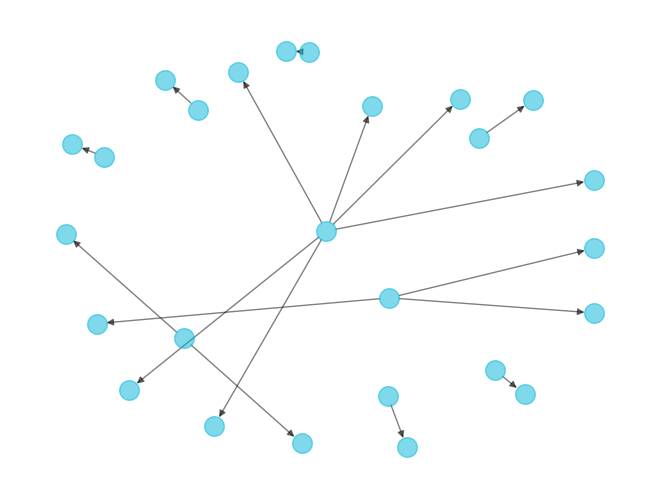

In [ ]:
"""
Graph 1: User Interaction
  - Nodes represent twitter users
  - Edges represent @'s, thus we use a Digraph to encapsulate this relationship between users
"""
counter = 250 #@param {type:"number"}
G = nx.DiGraph()
for index, row in tweets.iterrows():
  if index < counter:
    for tagged in ast.literal_eval(row['reply_to']):
      G.add_edge(row['username'], tagged)
      counter = counter + 1
  else:
    break
nx.draw(G,
        node_size=200,
        alpha=0.5,
        node_color='#00b4d9',
        with_labels=False
        )

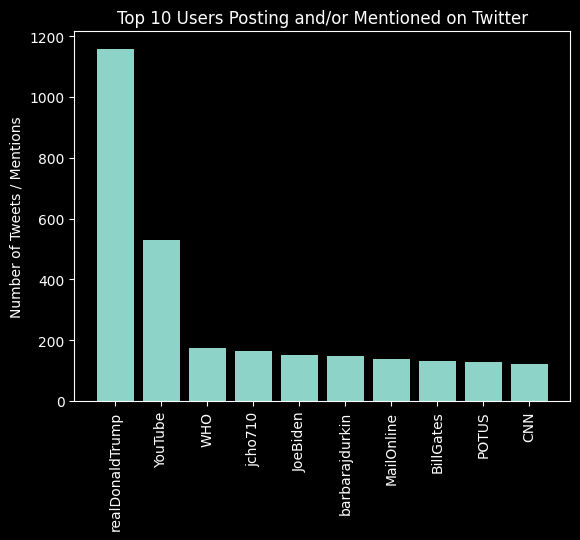

In [10]:
plt.title('Top {} Users Posting and/or Mentioned on Twitter'.format(top_k_nodes))
plt.xlabel=("Username (Tag)")
plt.ylabel("Number of Tweets / Mentions")
plt.bar(plot_members.keys(),
        plot_members.values(),
        label='Twitter Contribution',
        )
plt.xticks(rotation='vertical')
plt.autoscale()
plt.show()

In [11]:
hashtags = []
for entry in tweets['hashtags']:
  if str(entry).strip() != 'None':
    hashtags += ast.literal_eval(entry.lower())
  else:
    hashtags.append('none')
hashtag_count = Counter(hashtags)

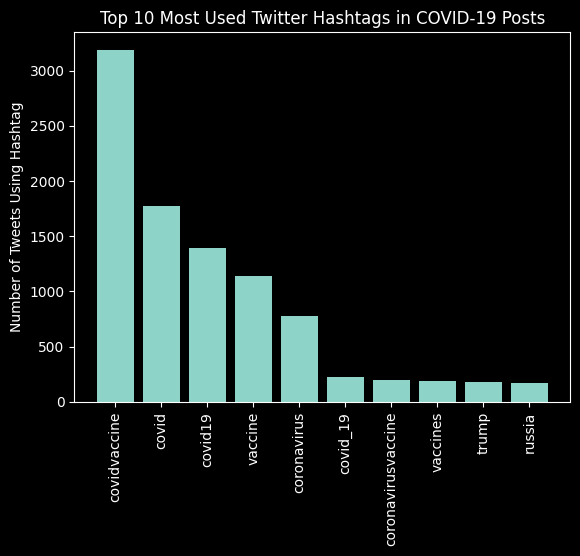

In [12]:
top_k_hashtags = 10 #@param{type:"integer"}
hashtags = hashtag_count.most_common(10)
plot_hashtags = {}
for entry in hashtags:
  plot_hashtags[entry[0]] = entry[1]

plt.title('Top {} Most Used Twitter Hashtags in COVID-19 Posts'.format(top_k_hashtags))
plt.xlabel=("Hashtags")
plt.ylabel("Number of Tweets Using Hashtag")
plt.bar(plot_hashtags.keys(),
        plot_hashtags.values(),
        label='Twitter Contribution',
        )
plt.xticks(rotation='vertical')
plt.autoscale()
plt.show()

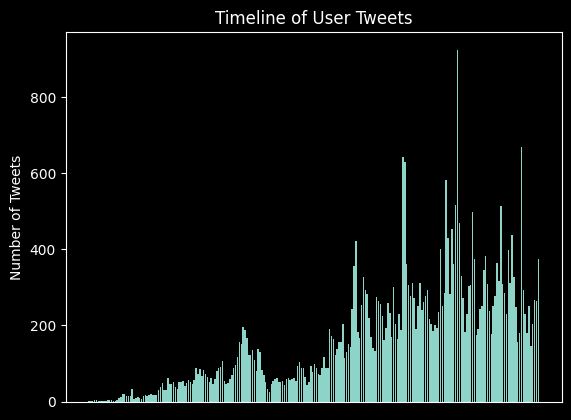

In [24]:
times = sorted(Counter(tweets['date']).most_common())
timeline = {}
for entry in times:
  timeline[entry[0]] = entry[1]
plt.title('Timeline of User Tweets')
plt.xlabel=("Date")
plt.ylabel("Number of Tweets")
plt.bar(timeline.keys(),
        timeline.values(),
        label='Tweets',
        )
plt.xticks([])
# plt.xticks(rotation='vertical')
plt.autoscale()
plt.show()

In [ ]:
"""
user_language = {}
for entry in Counter(tweets['language']).most_common():
  user_language[str(entry[0])] = entry[1]
print(user_language)
plt.title('Top Languages of COVID-19 Tweets')
plt.xlabel=("Language")
plt.ylabel("Number of Tweets")
plt.bar(user_language.keys(),
        user_language.values(),
        label='Tweets',
        )
plt.xticks(rotation='vertical')
plt.autoscale()
plt.show()
"""

'\nuser_language = {}\nfor entry in Counter(tweets[\'language\']).most_common():\n  user_language[str(entry[0])] = entry[1]\nprint(user_language)\nplt.title(\'Top Languages of COVID-19 Tweets\')\nplt.xlabel=("Language")\nplt.ylabel("Number of Tweets")\nplt.bar(user_language.keys(),\n        user_language.values(),\n        label=\'Tweets\',\n        )\nplt.xticks(rotation=\'vertical\')\nplt.autoscale()\nplt.show()\n'

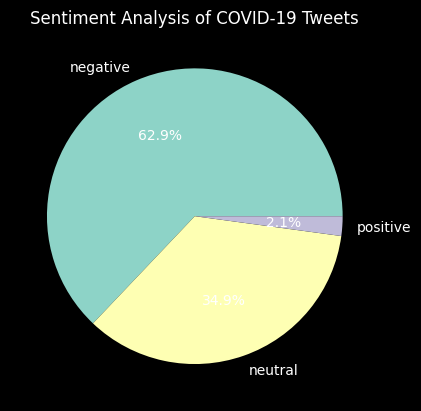

In [25]:
plt.title('Sentiment Analysis of COVID-19 Tweets'.format(top_k_nodes))
sentiment = Counter(tweets['sentiment'])
plt.pie(sentiment.values(), labels=sentiment.keys(), autopct='%1.1f%%')
plt.show()

Counter({'Contains Misinformation': 38320})


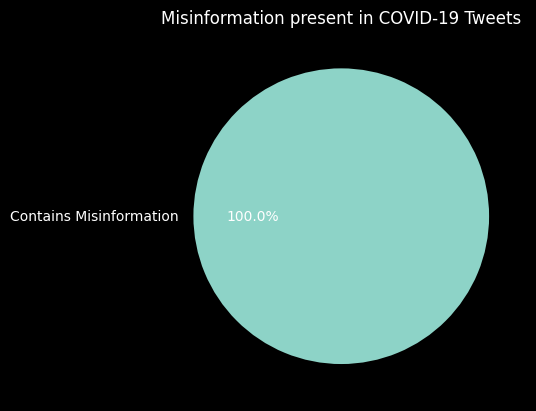

In [26]:
plt.title('Misinformation present in COVID-19 Tweets'.format(top_k_nodes))
validity = Counter(tweets['validity'])
plt.pie(validity.values(), labels=validity.keys(), autopct='%1.1f%%')
print(validity)
plt.show()

In [ ]:
"""
plt.title('Number of Verified versus Unverified Twitter Users')
user_types = Counter(tweets['user_verified'])
plt.pie(user_types.values(), labels=["Unverified", "Verified"], autopct='%1.1f%%')
print(validity)
plt.show()
"""

'\nplt.title(\'Number of Verified versus Unverified Twitter Users\')\nuser_types = Counter(tweets[\'user_verified\'])\nplt.pie(user_types.values(), labels=["Unverified", "Verified"], autopct=\'%1.1f%%\')\nprint(validity)\nplt.show()\n'

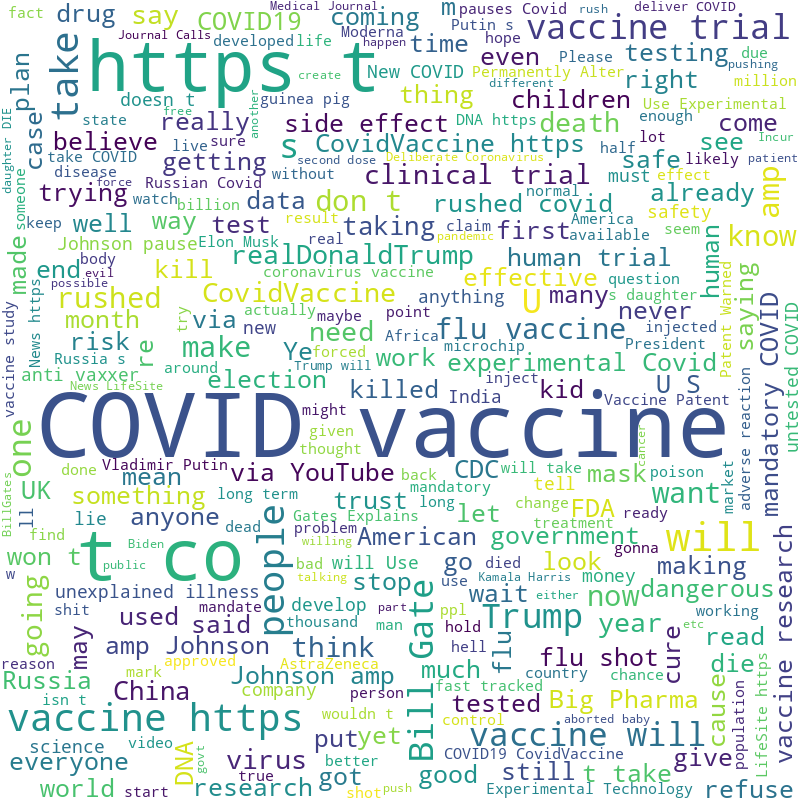

In [27]:
wv_all_tweets = WordCloud(
    background_color='white',
    width=800,
    height=800,
    stopwords=set(STOPWORDS),
    max_words=1000,
    min_font_size=12,
    random_state=2
)
wv_all_tweets.generate(' '.join(tweets['tweet']))
wv_all_tweets.to_image()

In [ ]:
"""
wv_all_tweets = WordCloud(
    background_color='white',
    width=800,
    height=800,
    stopwords=set(STOPWORDS),
    max_words=1000,
    min_font_size=12,
    random_state=2
)
wv_all_tweets.generate(' '.join(tweets['user_description'].dropna()))
wv_all_tweets.to_image()
"""

"\nwv_all_tweets = WordCloud(\n    background_color='white',\n    width=800,\n    height=800,\n    stopwords=set(STOPWORDS),\n    max_words=1000,\n    min_font_size=12,\n    random_state=2\n)\nwv_all_tweets.generate(' '.join(tweets['user_description'].dropna()))\nwv_all_tweets.to_image()\n"